# Map algebra on Raster objects

Please download data from https://geosaurus.maps.arcgis.com/home/item.html?id=b713f5b7fbd14c7597d9797b27b14835 and extract it. Then replace your path

In [1]:
crf_path = r'\\Mac\Home\Documents\GIS_data\Imagery\sentinel-5p\ny-2019-2020\ny_crf\ny_19_20.crf'
from arcgis.gis import GIS
from arcgis.raster import RasterCollection
from arcgis.raster import functions
import arcpy

In [3]:
all_rc = RasterCollection(crf_path)
# needs dev build for this to work
all_2019 = all_rc.filter_by_calendar_range('YEAR',2019,2019)
all_2020 = all_rc.filter_by_calendar_range('YEAR',2020,2020)
no2_19 = all_2019.filter_by_attribute(field_name='Variable', 
                                      operator='CONTAINS', field_values='nitrogendioxide')
qa_19 = all_2019.filter_by_attribute(field_name='Variable', 
                                     operator='CONTAINS', field_values='qa_value')

In [4]:
print(all_rc.count, all_2019.count, all_2020.count, no2_19.count, qa_19.count)

24 12 12 6 6


In [5]:
print(type(no2_19), type(qa_19))

<class 'arcgis.raster._layer.RasterCollection'> <class 'arcgis.raster._layer.RasterCollection'>


### Extract single Raster obj for map algebra

In [19]:
qa1 = qa_19[1]['Raster']
type(qa1)

arcgis.raster._layer.Raster

In [20]:
qa1._engine

arcgis.raster._layer._ArcpyRaster

In [21]:
qa1.minimum, qa1.mean, qa1.maximum

(-7.956242916407064e-05, 2.4805166235130113e-05, 0.0158010832965374)

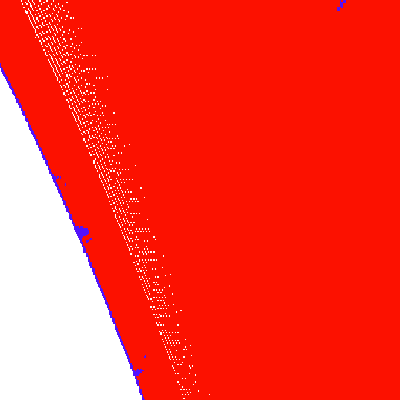

In [22]:
qa1

### Bug 1 - cannot do alegbra using operators

In [23]:
qa1 > 0.75

TypeError: '>' not supported between instances of 'Raster' and 'float'

### Bug 2 - cannot do algebra using functions

In [32]:
functions.greater_than_equal([qa1, 0.75])

ValueError: The truth value of a raster is ambiguous. Invalid use of raster with Boolean operator or function. Check the use of parentheses where applicable.

### Try using backend object - ArcPy in this case

In [24]:
arcpy_qa1 = qa1._engine_obj._raster
type(arcpy_qa1)

arcpy.sa.Raster.Raster

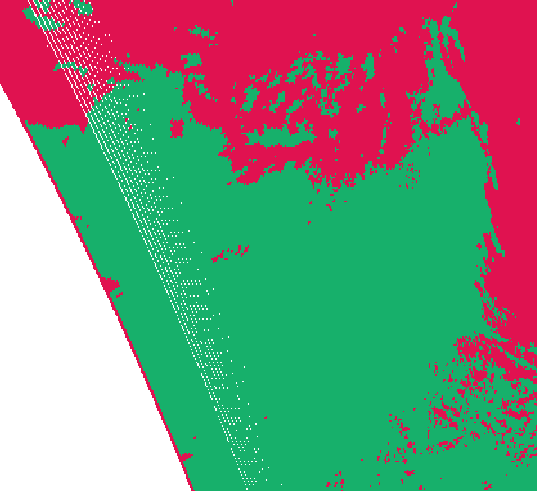

In [33]:
bool_ras_operator = arcpy_qa1 >= 0.75
bool_ras_operator

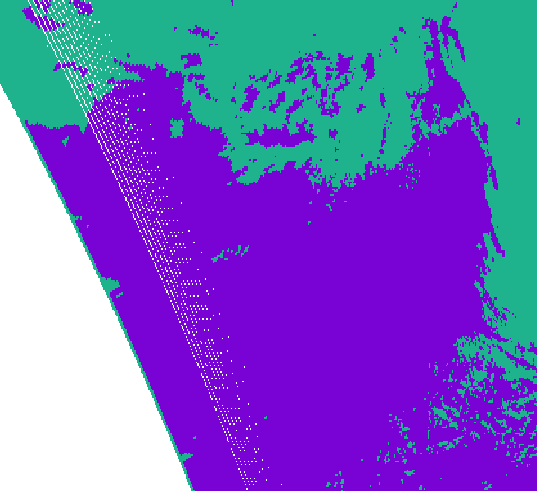

In [35]:
bool_ras_fn = arcpy.ia.GreaterThanEqual(arcpy_qa1, 0.75)
bool_ras_fn

### Bug 3 - Boolean raster thinks its multidimensional, whereas it should not

In [36]:
bool_ras_operator.isMultidimensional

True

In [40]:
# Check if source rasters are multidim
print("arcpy_qa1: ", arcpy_qa1.isMultidimensional)
print("qa1 (arcgis.raster.Raster): ", qa1.is_multidimensional)
print("")

arcpy_qa1:  False
qa1 (arcgis.raster.Raster):  False


In [28]:
arcpy_qa1.minimum, arcpy_qa1.mean, arcpy_qa1.maximum

(-7.956242916407064e-05, 2.4805166235130113e-05, 0.0158010832965374)

### Bug 1 - cannot run stretch function

In [47]:
no2_19[0]

{'Raster': <arcgis.raster._layer.Raster at 0x21eed5a9630>,
 'Variable': '/product/nitrogendioxide_tropospheric_column',
 'StdTime': '2019-04-01T00:00:00+00:00'}

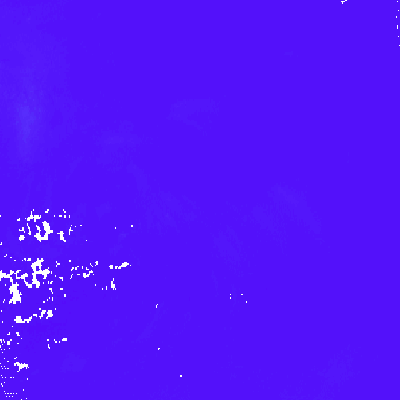

In [41]:
no2_1 = no2_19[0]['Raster']
no2_1

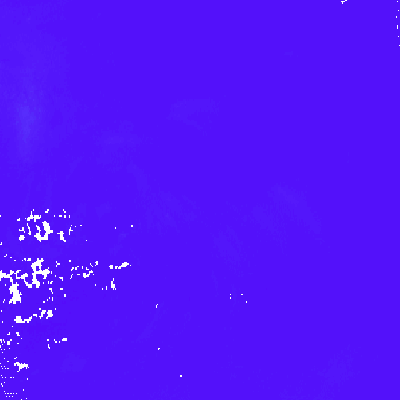

In [48]:
functions.stretch(no2_1, 'StdDev', num_stddev=2) # retuns the same result

### Run stretch using ArcPy

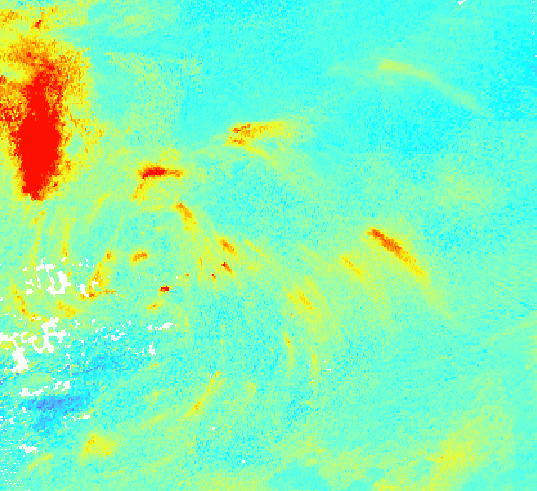

In [50]:
arcpy_no2_1 = no2_1._engine_obj._raster
arcpy.ia.Stretch(arcpy_no2_1, 'StdDev',num_stddev=2)  # outputs matches that of Pro

In [52]:
arcpy_no2_1.minimum, arcpy_no2_1.mean, arcpy_no2_1.maximum

(-7.956242916407064e-05, 2.4805166235130113e-05, 0.0158010832965374)

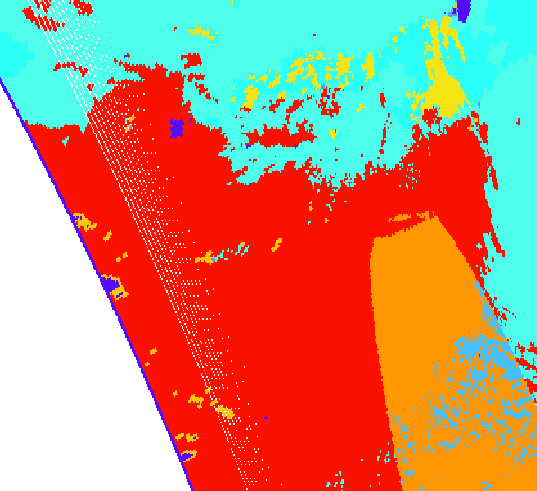

In [58]:
arcpy.ia.Stretch(arcpy_qa1, 'StdDev',num_stddev=2, dra=True)  # outputs matches that of Pro

In [57]:
arcpy_qa1.maximum

0.0158010832965374